In [1]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import urllib
import json
import os
import contextily as ctx
import numpy as np
import dask.dataframe as dd
# import tensorflow as tf

from adjustText import adjust_text
from shapely.geometry import Polygon

In [2]:
from tensorflow.signal import rfft

# Getting Data

## Hydrological Data

The list of stations used by the Federal Office of the environment can be found on this page: https://www.bafu.admin.ch/bafu/de/home/themen/wasser/daten-karten/wasser--messnetze/basismessnetz--wasserstand-und-abfluss-an-oberflaechengewaessern.html#46775952

In [5]:
station_list = pd.read_excel("data/hydrology/Stationsliste_HydrowebSAM_DE_Juli2023.xlsx", skiprows=4)

# Restrict list to stations which are active, are part of the aare system and where discharge is measured
aare_stations = station_list[
    (station_list["Betriebsstatus"] == "in Betrieb") & 
    (station_list["Flussgebiet"] == "Aaregebiet") & 
    (station_list["Messparameter"]  == "Abfluss")
]

# convert to geopandas for ease of plot
aare_stations = gpd.GeoDataFrame(
    aare_stations,
    geometry=gpd.points_from_xy(x=aare_stations["X-Koordinate"], y=aare_stations["Y-Koordinate"]),
    crs='EPSG:2056'
)

aare_stations.head()

,Betriebsstatus,Flussgebiet,Stationsnr.,Gewässer,Stationsname,Gewässertyp,X-Koordinate,Y-Koordinate,Stationshöhe [m ü.M.],Einzugsgebietsfläche [km2],Mittlere Einzugsgebietshöhe [m ü.M.],Vergletscherungsanteil [%],Messparameter,Daten verfügbar ab,Daten verfügbar bis,geometry
2,in Betrieb,Aaregebiet,70,Emme,Emmenmatt,Fliessgewässer,2623616,1200426.0,641,443.0,1065.0,0.0,Abfluss,1909-01-01,heute,POINT (2623616 1200426)
4,in Betrieb,Aaregebiet,155,Emme,"Wiler, Limpachmündung",Fliessgewässer,2608228,1223238.0,459,937.0,858.0,0.0,Abfluss,1921-07-01,heute,POINT (2608228 1223238)
27,in Betrieb,Aaregebiet,488,Simme,Latterbach,Fliessgewässer,2610681,1167849.0,666,563.0,1594.0,1.5,Abfluss,1985-05-01,heute,POINT (2610681 1167849)
60,in Betrieb,Aaregebiet,2016,Aare,Brugg,Fliessgewässer,2656959,1259353.0,336,11681.0,1000.0,1.5,Abfluss,1916-01-01,heute,POINT (2656959 1259353)
70,in Betrieb,Aaregebiet,2019,Aare,Brienzwiler,Fliessgewässer,2649942,1177374.0,574,555.0,2135.0,15.5,Abfluss,1905-01-01,heute,POINT (2649942 1177374)


Choice (up for debate): Aare-Hagneck as target which has `Stationsnr. = 2085`

In [6]:
def get_catchment_geometry(station_no: str) -> gpd.GeoDataFrame | int:
    try:
        with urllib.request.urlopen(f"https://api3.geo.admin.ch/rest/services/api/MapServer/ch.bafu.hydrologie-hydromessstationen/{station_no}") as url:
            data = json.load(url)
            geometry = data.get('feature').get('geometry')
        # somewhat strong assumption: it seems, the geometry for all stations is defined as a ring - convert to shapely.Polygon
        catchment_geom = Polygon(geometry['rings'][0])
        catchment_geom = gpd.GeoDataFrame([{'geometry': catchment_geom}], crs="EPSG:21781") #EPSG:21781 the LV95 coordinate projection
        return catchment_geom
    except Exception as e:
        print(f"Something went wrong: {e}")
        return 0

catchment = get_catchment_geometry("2085")

In [7]:
# change the coordinate projection to the OpenStreetMap projection
catchment = catchment.to_crs(epsg=3857)
aare_stations = aare_stations.to_crs(epsg=3857)

# create a column whether a station is in catchment = is upriver 
aare_stations["in_catchment"] = aare_stations.geometry.apply(lambda geom: catchment.geometry[0].contains(geom))

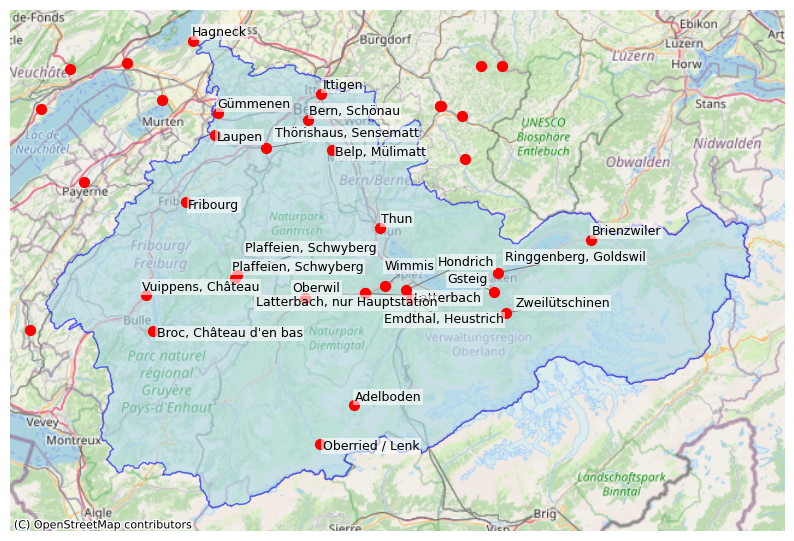

In [8]:
# Plot with map
fig, ax = plt.subplots(figsize=(10, 8))
catchment.plot(ax=ax, facecolor="lightblue", edgecolor="blue", alpha=0.6)

# Add basemap (OpenStreetMap tiles)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Add hydrological stations and name those in catchment
aare_stations.plot(ax=ax, color="red", markersize=50, zorder=5)

texts = []
for idx, row in aare_stations[aare_stations["in_catchment"]==True].iterrows():
    texts.append(
        ax.text(
            row.geometry.x,
            row.geometry.y,
            row["Stationsname"],
            fontsize=9,
            color="black",
            bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", pad=1),
            zorder=6
        )
    )

# Adjust positions to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle="->", color="gray", lw=0.8))


ax.set_axis_off()
plt.show()

In [9]:
# Load data
hydro = pd.read_csv("data/hydrology/aare_2010.csv")
for year in np.arange(2011, 2025):
    tmp = pd.read_csv(f"data/hydrology/aare_{year}.csv")
    hydro = pd.concat([hydro, tmp])

# convert index to datetime
date_time = pd.to_datetime(hydro['timestamp'], format='%Y-%m-%d %H:%M:%S.000000 UTC')
hydro = hydro.set_index(date_time)

# convert to wide data frame
wide_hydro = hydro.pivot(index="timestamp", columns="station_no", values="value")

# convert column names to str
wide_hydro.columns = wide_hydro.columns.astype(str)

wide_hydro.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
station_no,,,,,,,,
2019,788976.0,36.893135,25.401705,2.213,16.802,30.3090,52.54100,367.108
2030,788976.0,111.646131,69.643343,24.948,56.587,91.8940,154.59400,499.180
2085,788976.0,168.991260,96.377453,17.592,98.677,151.3480,213.13100,1163.731
2109,788976.0,18.848872,17.321321,1.459,5.081,12.3350,29.14500,225.255
2135,788976.0,122.280430,71.774729,30.980,66.500,102.8145,163.25400,561.400
2159,788976.0,2.742226,3.134101,0.008,1.188,1.9330,3.10400,64.049
2160,788976.0,19.977767,20.385589,1.789,6.281,10.4340,28.55600,444.608
2179,788976.0,8.195178,9.975646,1.283,3.223,5.5150,9.05600,297.040
2215,788976.0,49.067556,48.117895,3.738,11.836,22.7040,82.77425,856.441


In [4]:
wide_hydro = wide_hydro.interpolate(method="linear")
wide_hydro.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
station_no,,,,,,,,
2019,788976.0,36.893135,25.401705,2.213,16.802,30.3090,52.54100,367.108
2030,788976.0,111.646131,69.643343,24.948,56.587,91.8940,154.59400,499.180
2085,788976.0,168.991260,96.377453,17.592,98.677,151.3480,213.13100,1163.731
2109,788976.0,18.848872,17.321321,1.459,5.081,12.3350,29.14500,225.255
2135,788976.0,122.280430,71.774729,30.980,66.500,102.8145,163.25400,561.400
2159,788976.0,2.742226,3.134101,0.008,1.188,1.9330,3.10400,64.049
2160,788976.0,19.977767,20.385589,1.789,6.281,10.4340,28.55600,444.608
2179,788976.0,8.195178,9.975646,1.283,3.223,5.5150,9.05600,297.040
2215,788976.0,49.067556,48.117895,3.738,11.836,22.7040,82.77425,856.441


### Seasonal cycle?

Does our target Hagneck show a clear seasonal cycle? To answer, let's perform a quick fourier transformation

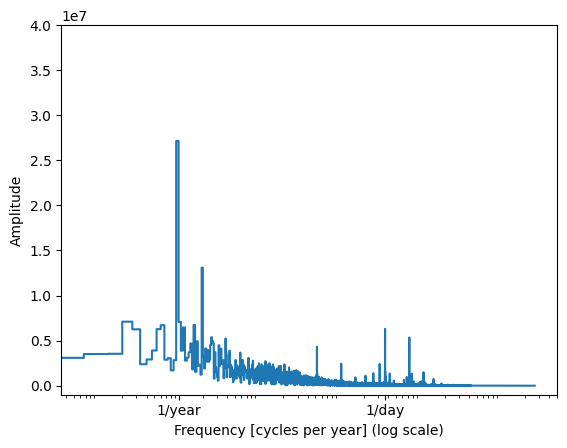

In [6]:

# Your series for station 2085
x = wide_hydro["2085"].values
n_samples = len(x)

# --- FFT ---
fft = rfft(x)

# --- Frequency axis ---
# Assume your data is hourly → sampling interval = 1 hour
dt = 1.0/6.0   # hours
freqs_per_hour = np.fft.rfftfreq(n_samples, d=dt)

# Convert to cycles per year (instead of per hour)
hours_per_year = 24 * 365.2524
freqs_per_year = freqs_per_hour * hours_per_year

# --- Plot ---
plt.step(freqs_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(-0.01e8, 0.4e8)
plt.xticks([1, 365.2524], labels=['1/year', '1/day'])
plt.xlabel("Frequency [cycles per year] (log scale)")
plt.ylabel("Amplitude")
plt.show()


Most pronounced cycle: ~1.00 years


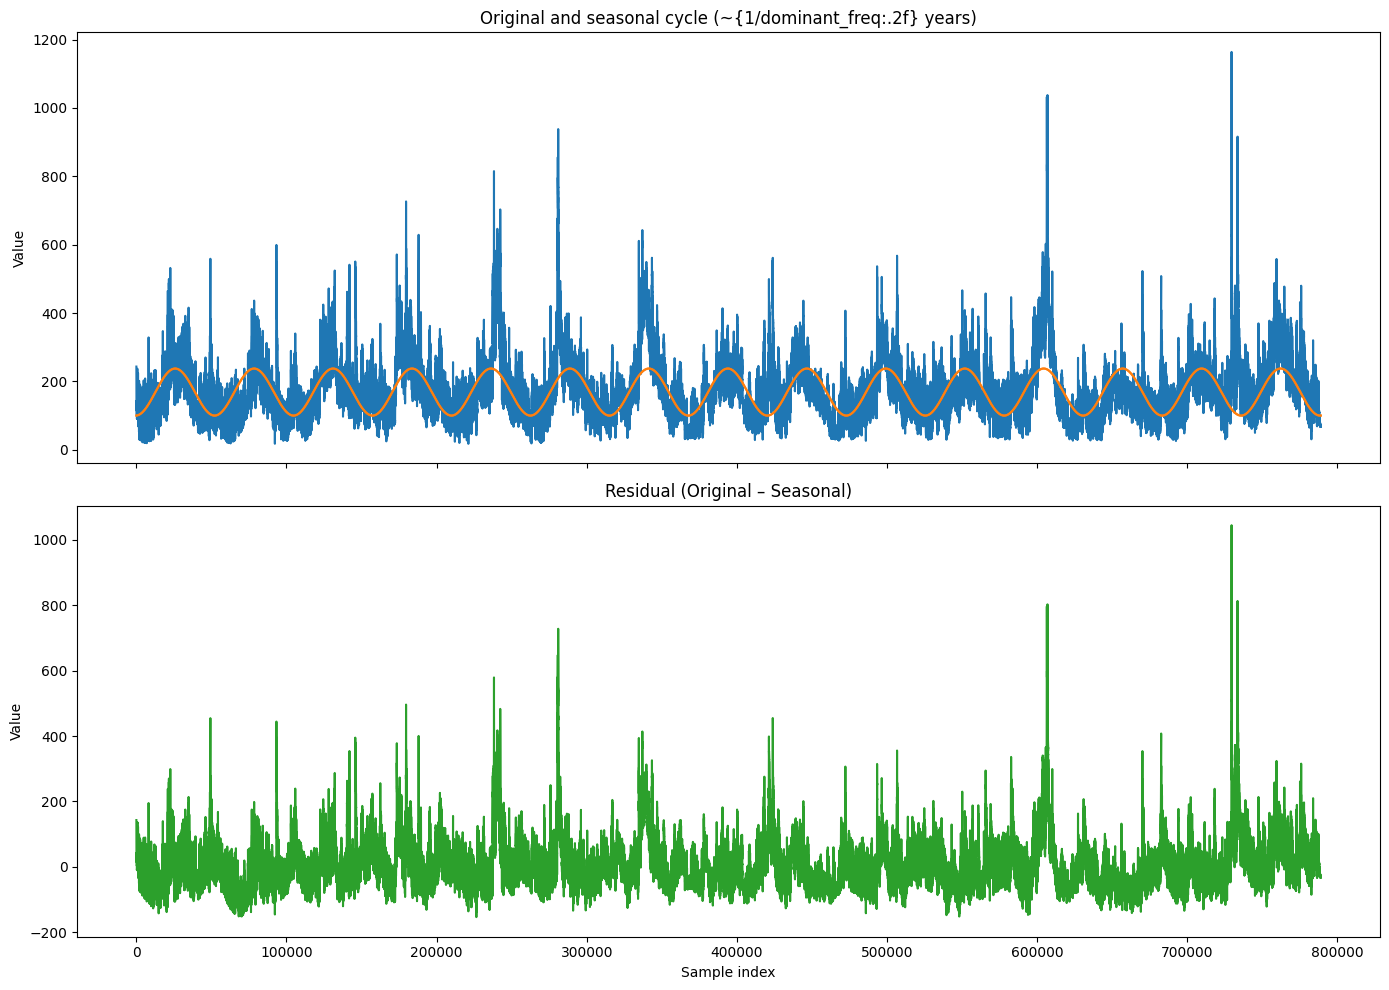

In [7]:
# --- Find dominant frequency ---
power = np.abs(fft)**2
dominant_idx = np.argmax(power[1:]) + 1
dominant_freq = freqs_per_year[dominant_idx]
print(f"Most pronounced cycle: ~{1/dominant_freq:.2f} years")

# --- Reconstruct seasonal component ---
fft_yearly = np.zeros_like(fft, dtype=complex)
fft_yearly[0] = fft[0]                         # keep mean
fft_yearly[dominant_idx] = fft[dominant_idx]   # keep strongest seasonal
seasonal = np.fft.irfft(fft_yearly, n=n_samples)

# --- Residual ---
residual = x - seasonal

# --- Subplots ---
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

axes[0].plot(x, color="C0")
axes[0].set_title("Original and seasonal cycle (~{1/dominant_freq:.2f} years)")
axes[0].plot(seasonal, color="C1")
axes[0].plot(seasonal, color="C1")

axes[1].plot(residual, color="C2")
axes[1].set_title("Residual (Original – Seasonal)")

for ax in axes:
    ax.set_ylabel("Value")
axes[-1].set_xlabel("Sample index")

plt.tight_layout()
plt.show()


In [24]:
# ensure DatetimeIndex
wide_hydro.index = pd.to_datetime(wide_hydro.index)
idx = wide_hydro.index  # DatetimeIndex

# day-of-year (1..366), seconds within the day, and days-in-year per timestamp
day_of_year = idx.dayofyear
seconds_of_day = idx.hour * 3600 + idx.minute * 60 + idx.second + idx.microsecond / 1e6
days_in_year = np.where(idx.is_leap_year, 366, 365)

# fractional position in that specific calendar year (0..1)
frac_of_year = ((day_of_year - 1) + seconds_of_day / 86400.0) / days_in_year

wide_hydro['year_sin'] = np.sin(2 * np.pi * frac_of_year)
wide_hydro['year_cos'] = np.cos(2 * np.pi * frac_of_year)


In [25]:
train_hydro = wide_hydro.loc['2010-01-01':'2023-12-31']
test_hydro = wide_hydro.loc['2024-01-01':]

y_train = train_hydro.pop("2085")
y_test = test_hydro.pop("2085")

In [52]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

steps = [
    ("scaler", StandardScaler()),
    ("lin_reg", LinearRegression())
]
pipeline = Pipeline(steps)

# Fit pipeline directly
pipeline.fit(train_hydro, y_train)

# Predict & evaluate
y_pred = pipeline.predict(test_hydro)
rmse = np.mean((y_test - y_pred)**2)**0.5
print("Root Mean Squared Error:", rmse)
r2 = r2_score(y_test, y_pred)
print("R2:", r2)

Root Mean Squared Error: 38.267581982689364
R2: 0.7938562771901408


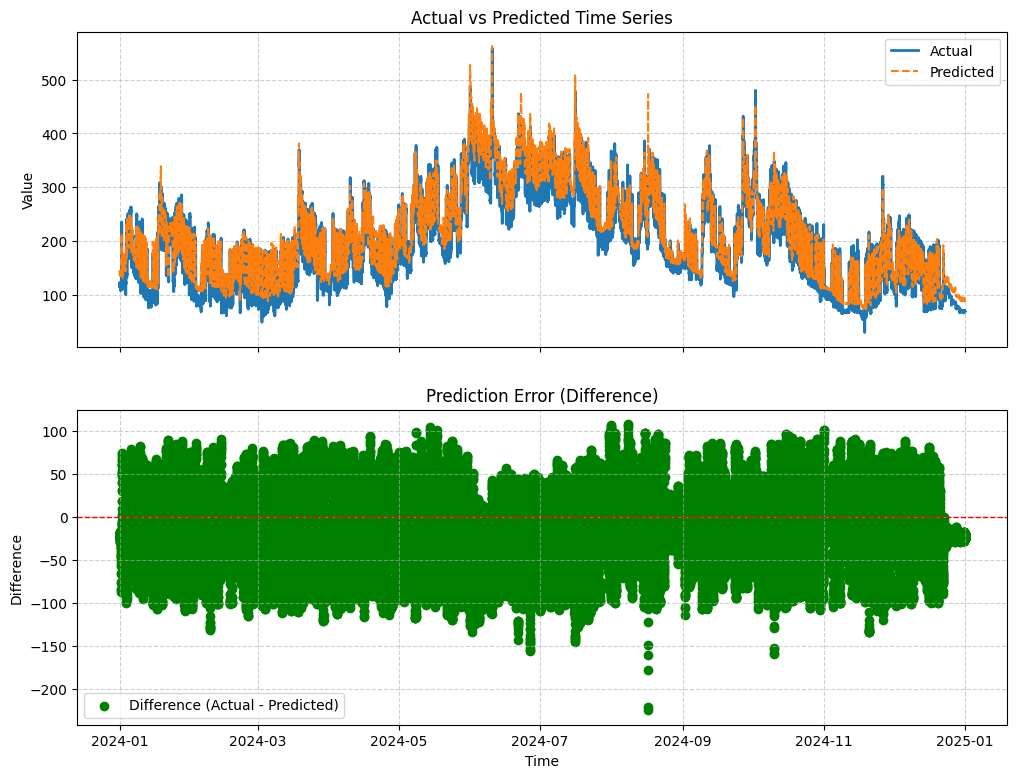

In [53]:
# Make sure y_pred is a pandas Series with the same index as y_test
y_pred_series = pd.Series(y_pred, index=y_test.index)

def plot_time_series(y_pred: pd.Series, y_test: pd.Series):
    fig, axs = plt.subplots(2, 1, figsize=(12, 9), sharex=True)

    axs[0].plot(y_test.index, y_test, label="Actual", linewidth=2)
    axs[0].plot(y_test.index, y_pred, label="Predicted", linestyle="--")
    axs[0].set_ylabel("Value")
    axs[0].set_title("Actual vs Predicted Time Series")
    axs[0].legend()
    axs[0].grid(True, linestyle='--', alpha=0.6)

    difference = y_test.values - y_pred.values
    axs[1].scatter(y_test.index, difference, label="Difference (Actual - Predicted)", color='green')
    # Add a horizontal line at y=0 for reference
    axs[1].axhline(y=0, color='r', linestyle='--', linewidth=1)
    axs[1].set_xlabel("Time")
    axs[1].set_ylabel("Difference")
    axs[1].set_title("Prediction Error (Difference)")
    axs[1].legend()
    axs[1].grid(True, linestyle='--', alpha=0.6)

    plt.show()

plot_time_series(y_pred_series, y_test)

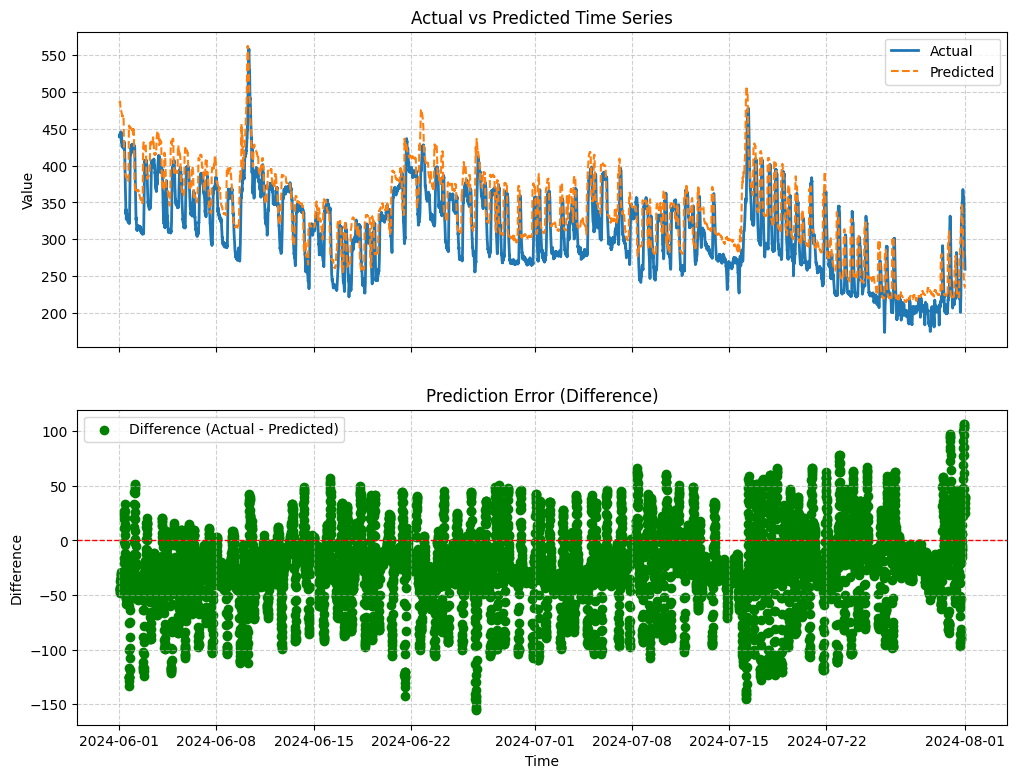

In [38]:
start = "2024-06-01"
end = "2024-08-01"

plot_time_series(y_pred_series[(y_pred_series.index > start) & (y_pred_series.index < end)], y_test[(y_test.index > start) & (y_test.index < end)])
# y_test[(y_test.index > start) & (y_test.index < end)]

In [54]:
# plt.scatter(y_pred, y_test, alpha=0.01, label="Predicted vs. Measured")
# max_val = max(y_test.max(), y_pred_series.max())
# min_val = min(y_test.min(), y_pred_series.min())
# plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="Perfect Prediction")
# var_y_test = y_test.var()
# var_y_pred = y_pred_series.var()
# plt.text(min_val + (max_val - min_val) * 0.05, max_val - (max_val - min_val) * 0.1, 
#          f"Actual Variance: {var_y_test:.2f}",
#          fontsize=10)

# plt.text(min_val + (max_val - min_val) * 0.05, max_val - (max_val - min_val) * 0.15,
#          f"Predicted Variance: {var_y_pred:.2f}",
#          fontsize=10)


### Simple linear regression - with time awareness

In [45]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

class DaskLagFeaturesAdder(BaseEstimator, TransformerMixin):
    # Add an 'exclude_columns' parameter
    def __init__(self, n_lags=1, exclude_columns=None):
        self.n_lags = n_lags
        self.exclude_columns = exclude_columns if exclude_columns is not None else []

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        if self.n_lags == 0:
            return X
            
        X_with_lags = X

        for i in range(1, self.n_lags + 1):
            # Only loop through columns that are NOT in the exclude list
            for col in [c for c in X.columns if c not in self.exclude_columns]:
                new_col_name = f'{col}_lag_{i}'
                X_with_lags = X_with_lags.assign(
                    **{new_col_name: X[col].shift(periods=i)}
                )

        return X_with_lags.bfill()
    
    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            raise ValueError("Input feature names are required.")
        
        feature_names = list(input_features)
        if self.n_lags > 0:
            # Create lagged names only for the included columns
            columns_to_lag = [c for c in input_features if c not in self.exclude_columns]
            for i in range(1, self.n_lags + 1):
                for col in columns_to_lag:
                    feature_names.append(f'{col}_lag_{i}')
        return np.array(feature_names, dtype=object)

In [36]:
# Due to performance issue
# Define the target station, lag, and seasonal features
target_station = '2085'
seasonal_features = ['year_sin', 'year_cos']
upstream_stations = [col for col in train_hydro.columns if col not in [target_station] + seasonal_features]

# Load the data again using dask now instead of pandas
file_path = [f"data/hydrology/aare_{year}.csv" for year in np.arange(2010,2024)]
long_format_dd = dd.read_csv(file_path)
long_format_dd['station_no'] = long_format_dd['station_no'].astype('category').cat.as_known()

wide_hydro_dd = long_format_dd.pivot_table(index="timestamp", columns="station_no", values='value')

train_hydro_dd = wide_hydro_dd.map_partitions(lambda df: df.interpolate(method="linear"))
train_hydro_dd.index = dd.to_datetime(train_hydro_dd.index)
train_hydro_dd.columns = [f'{col}' for col in train_hydro_dd.columns]

# add the seasonal cycle lazily
day_of_year = train_hydro_dd.index.dayofyear
days_in_year = 365.25

train_hydro_dd = train_hydro_dd.assign(
    year_sin = np.sin(2 * np.pi * day_of_year / days_in_year),
    year_cos = np.cos(2 * np.pi * day_of_year / days_in_year)
)

y_train = train_hydro_dd[target_station].compute()

# The features (X) remain a lazy Dask DataFrame.
X_train = train_hydro_dd.drop(columns=target_station)

In [ ]:
from dask_ml.model_selection import GridSearchCV

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet

# Add a StandardScaler to the numerical pipeline
numerical_pipeline = Pipeline([
    ('lag_adder', DaskLagFeaturesAdder(n_lags=2)),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical_features', numerical_pipeline, upstream_stations)
    ],
    remainder='passthrough'
)

# Create the final pipeline
regression_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', ElasticNet(max_iter=2000))
])

# Define the parameter grid to search
# 'preprocessor__lag_adder__n_lags' refers to the 'n_lags' parameter
# of the 'lag_adder' step, which is inside the 'preprocessor' step.
param_grid = {
    'preprocessor__numerical_features__lag_adder__n_lags': [0, 6, 12, 24, 30],
    'regressor__alpha': [0.1, 1.0, 10.0],
    'regressor__l1_ratio': [0.1, 0.5, 0.9]
}

# Create and fit the GridSearchCV object
# cv=5 means 5-fold cross-validation
# n_jobs=-1 uses all available CPU cores for faster computation
grid_search = GridSearchCV(
    regression_pipeline, 
    param_grid, 
    cv=3,  # Using 3-fold CV as an example
    n_jobs=-1, 
    scoring='neg_mean_squared_error'
)

print("\nStarting Grid Search... Dask will now execute the plan.")
# This is the only step where the full computation happens. Dask's scheduler
# will process the data in chunks to avoid memory errors.
grid_search.fit(X_train, y_train)

# Print the results
print("\n--- Grid Search Complete ---")
print("\nBest Parameters Found:")
print(grid_search.best_params_)
print("\nBest Cross-Validation Score (Negative Mean Squared Error):")
print(grid_search.best_score_)

It seems, that the best fit is at the edge of our grid. To make sure, we extend it, but we keep the best found parameter for $\alpha$ and $L1$.

In [16]:
new_param_grid = {
    # Test new, higher values for n_lags
    'preprocessor__numerical_features__lag_adder__n_lags': [30, 36, 42],
    
    # LOCK the other parameters to their previously found best values
    'regressor__alpha': [0.1],
    'regressor__l1_ratio': [0.9]
}

# Create and fit a NEW GridSearchCV object
new_grid_search = GridSearchCV(
    regression_pipeline, # Your original, unchanged pipeline
    new_param_grid, 
    cv=3,
    n_jobs=-1, 
    scoring='neg_mean_squared_error'
)

# Fit the new, faster search (assuming X_train, y_train are your training data)
print("Starting new focused grid search...")
new_grid_search.fit(X_train, y_train)
print("New search complete!")

# Print the results of the second run
print(f"Best parameters from second run: {new_grid_search.best_params_}")
print(f"Best score from second run (Neg MSE): {new_grid_search.best_score_}")

Starting new focused grid search...
New search complete!
Best parameters from second run: {'preprocessor__numerical_features__lag_adder__n_lags': 36, 'regressor__alpha': 0.1, 'regressor__l1_ratio': 0.9}
Best score from second run (Neg MSE): -174.53973559774553


In [34]:
best_model = new_grid_search.best_estimator_

y_pred = best_model.predict(test_hydro)
rmse = np.mean((y_test - y_pred)**2)**0.5
print("Root Mean Squared Error:", rmse)
r2 = r2_score(y_test, y_pred)
print("R2:", r2)

Root Mean Squared Error: 14.207493245855488
R2: 0.971585305652014


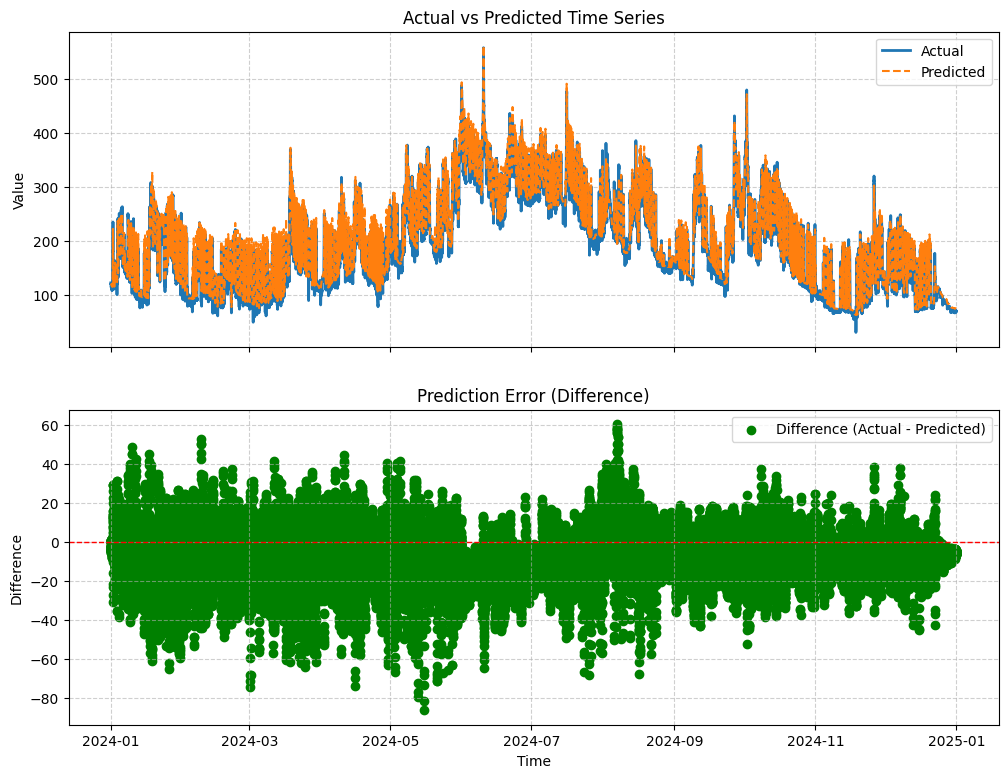

In [ ]:
# def plot_time_series(y_pred: pd.Series, y_test: pd.Series):
#     fig, axs = plt.subplots(2, 1, figsize=(12, 9), sharex=True)

#     axs[0].plot(y_test.index, y_test, label="Actual", linewidth=2)
#     axs[0].plot(y_test.index, y_pred, label="Predicted", linestyle="--")
#     axs[0].set_ylabel("Value")
#     axs[0].set_title("Actual vs Predicted Time Series")
#     axs[0].legend()
#     axs[0].grid(True, linestyle='--', alpha=0.6)

#     difference = y_test.values - y_pred.values
#     axs[1].scatter(y_test.index, difference, label="Difference (Actual - Predicted)", color='green')
#     # Add a horizontal line at y=0 for reference
#     axs[1].axhline(y=0, color='r', linestyle='--', linewidth=1)
#     axs[1].set_xlabel("Time")
#     axs[1].set_ylabel("Difference")
#     axs[1].set_title("Prediction Error (Difference)")
#     axs[1].legend()
#     axs[1].grid(True, linestyle='--', alpha=0.6)

#     plt.show()

plot_time_series(y_pred_series, y_test)

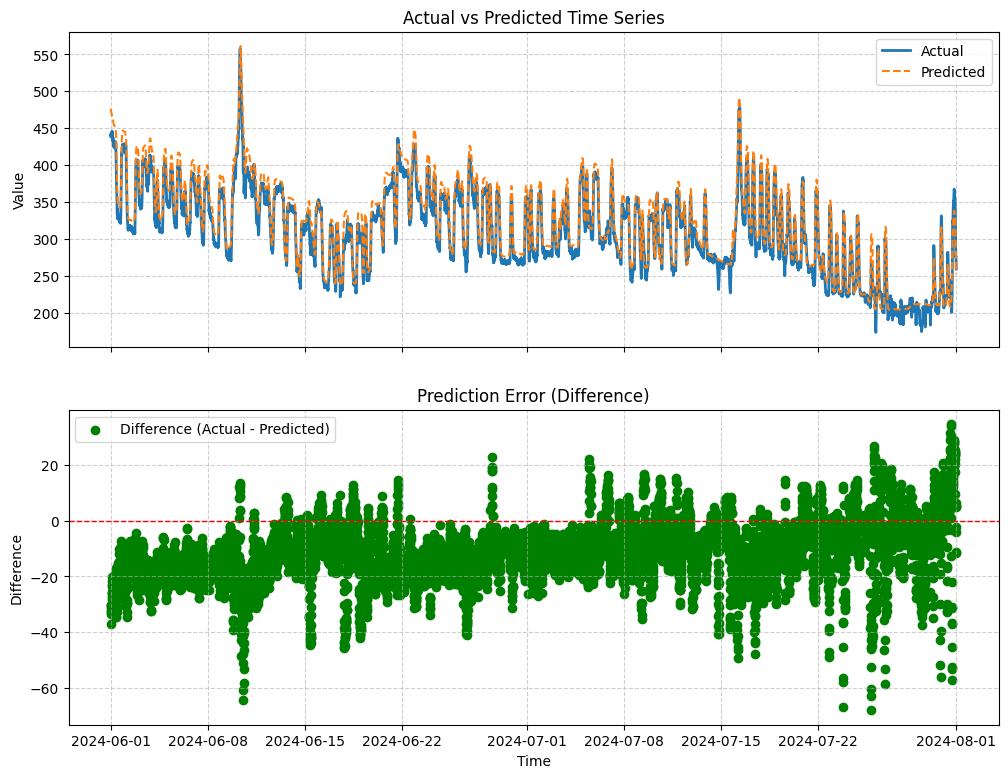

In [31]:
start = "2024-06-01"
end = "2024-08-01"

plot_time_series(y_pred_series[(y_pred_series.index > start) & (y_pred_series.index < end)], y_test[(y_test.index > start) & (y_test.index < end)])

### PCA as feature engineering

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# This pipeline will create lags, scale, and then apply PCA.
# We pass the seasonal_features to the 'exclude_columns' parameter
station_pipeline = Pipeline([
    ('lag_adder', DaskLagFeaturesAdder(n_lags=2, exclude_columns=seasonal_features)),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95))
])

time_feature_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

# Correct the third item in the second tuple
preprocessor = ColumnTransformer(
    transformers=[
        ('station_processing', station_pipeline, upstream_stations),
        ('time_feature_processing', time_feature_pipeline, seasonal_features)
    ],
    remainder='drop'
)

# This preprocessor now correctly handles both sets of features.
regression_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', ElasticNet(max_iter=2000))
])

param_grid = {
    'preprocessor__station_processing__lag_adder__n_lags': [36],
    'regressor__alpha': [0.1],
    'regressor__l1_ratio': [0.9]
}

# Create and fit the GridSearchCV object
# cv=5 means 5-fold cross-validation
# n_jobs=-1 uses all available CPU cores for faster computation
grid_search_pca = GridSearchCV(
    regression_pipeline, 
    param_grid, 
    cv=3,  # Using 3-fold CV as an example
    n_jobs=-1, 
    scoring='neg_mean_squared_error'
)

grid_search_pca.fit(X_train, y_train)


,estimator,Pipeline(step..._iter=2000))])
,param_grid,"{'preprocessor__station_...sing__lag_adder__n_lags': [36], 'regressor__alpha': [0.1], 'regressor__l1_ratio': [0.9]}"
,scoring,'neg_mean_squared_error'
,iid,True
,refit,True
,cv,3
,error_score,'raise'
,return_train_score,False
,scheduler,None
,n_jobs,-1
,cache_cv,True


In [67]:
model_pca = grid_search_pca.best_estimator_

y_pred = model_pca.predict(test_hydro)
rmse = np.mean((y_test - y_pred)**2)**0.5
print("Root Mean Squared Error:", rmse)
r2 = r2_score(y_test, y_pred)
print("R2:", r2)

Root Mean Squared Error: 17.68318735209441
R2: 0.9559821152686127


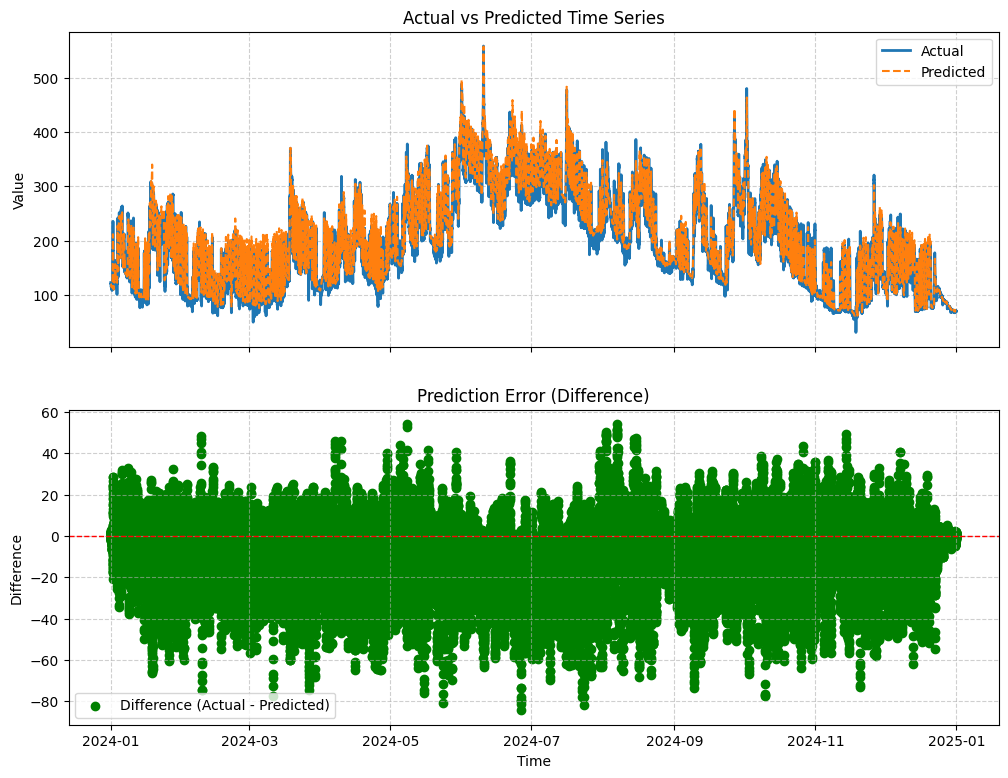

In [68]:
y_pred_series = pd.Series(y_pred, index=y_test.index)
plot_time_series(y_pred_series, y_test)

In [23]:
import pickle

# Access the best-performing model from your grid search
best_model = grid_search.best_estimator_

# Define the file path for saving the model
model_filepath = 'best_hydro_regression_model_with_lag.pkl'

# Save the model to a file
with open(model_filepath, 'wb') as file:
    pickle.dump(best_model, file)

print(f"Model successfully saved to {model_filepath}")

Model successfully saved to best_hydro_regression_model_with_lag.pkl


In [ ]:
import pickle

# Define the file path for the saved model
model_filepath = 'best_hydro_regression_model.pkl'

# Load the model from the file
with open(model_filepath, 'rb') as file:
    loaded_model = pickle.load(file)

print("Model successfully loaded.")
print(loaded_model)

# You can now use the loaded model to make new predictions
# loaded_model.predict(new_data)

## Recurrent Neural Networks

In [66]:
# We introduce a validation dataset now which we will use to train the RNN
# We will use 4 years for training and 1 for validation and test
column_indices = {name: i for i, name in enumerate(wide_hydro.columns)}

train_hydro = wide_hydro.loc['2019-01-01':'2022-12-31']
valid_hydro = wide_hydro.loc["2023-01-01":"2023-12-31"]
test_hydro = wide_hydro.loc['2024-01-01':]

# y_train = train_hydro.pop("2085")
# y_valid = valid_hydro.pop("2085")
# y_test = test_hydro.pop("2085")

In [77]:
import tensorflow as tf 

class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_hydro, val_df=valid_hydro, test_df=test_hydro,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
  
  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels
  
  def plot(self, model=None, plot_col='2085', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col}')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()

    plt.xlabel('Time [10\']')

  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds
  
  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result




In [64]:
w1 = WindowGenerator(input_width=6, label_width=1, shift=1, label_columns=["2085"])
w1.train.element_spec

(TensorSpec(shape=(None, 6, 15), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [65]:
for example_inputs, example_labels in w1.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 15)
Labels shape (batch, time, features): (32, 1, 1)


### Baseline: predict the last step

In [67]:
# Define class for Baseline Model
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

# Define a single step window
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['2085'])

# define, compile and train
baseline = Baseline(label_index=column_indices['2085'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

1643/1643 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - loss: 17.4046 - mean_absolute_error: 2.6034


In [82]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['2085'])

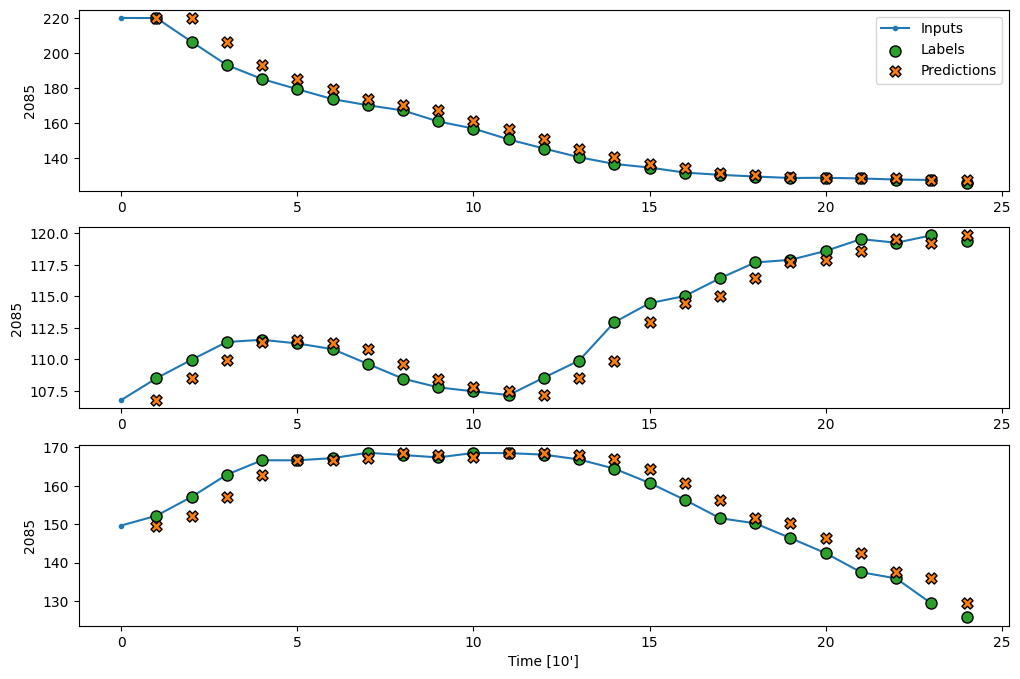

In [83]:
wide_window.plot(baseline)

### Single Step RNN

For now, I use the previously found window width of `12`

In [95]:
wide_window = WindowGenerator(
    input_width=12, label_width=12, shift=1, label_columns=['2085']
)

lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(units=1)
])

MAX_EPOCHS = 50

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy', 'mean_absolute_error'])
                #metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [96]:
history = compile_and_fit(lstm_model, wide_window)
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

Epoch 1/50
6575/6575 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.0000e+00 - loss: 18345.0527 - mean_absolute_error: 93.9752 - val_accuracy: 0.0000e+00 - val_loss: 12468.6104 - val_mean_absolute_error: 58.4892
Epoch 2/50
6575/6575 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.0000e+00 - loss: 4805.8462 - mean_absolute_error: 25.3790 - val_accuracy: 0.0000e+00 - val_loss: 4868.2910 - val_mean_absolute_error: 18.5870
Epoch 3/50
6575/6575 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.0000e+00 - loss: 1742.7395 - mean_absolute_error: 8.6669 - val_accuracy: 0.0000e+00 - val_loss: 2657.9146 - val_mean_absolute_error: 9.8827
Epoch 4/50
6575/6575 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.0000e+00 - loss: 915.5096 - mean_absolute_error: 4.7669 - val_accuracy: 0.0000e+00 - val_loss: 1707.6047 - val_mean_absolute_error: 6.8761
Epoch 5/50
6575/6575 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.0000e+00 - loss: 600.6663 - mean_absolute_error: 3.7414 - val_accuracy: 0.0000e+00 - val_l

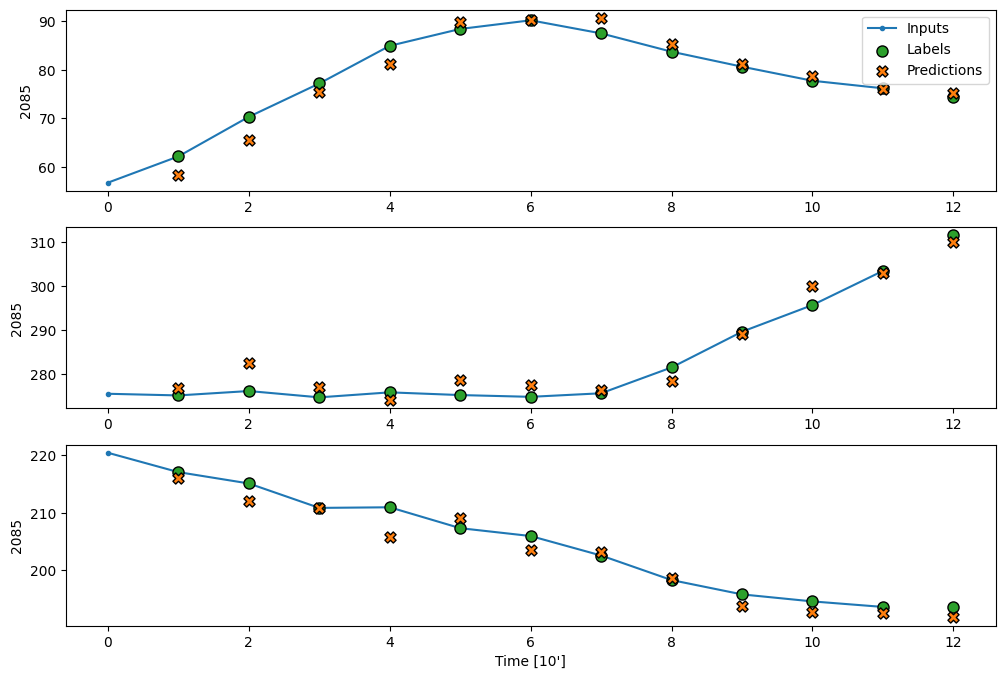

In [97]:
wide_window.plot(lstm_model)

In [98]:
lstm_model.predict(y_test)

ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(32, 1), dtype=float32). Expected shape (None, 12, 15), but input has incompatible shape (32, 1)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 1), dtype=float32)
  • training=False
  • mask=None
  • kwargs=<class 'inspect._empty'>

## Meteorological stations

In [49]:
meteo_stations = pd.read_csv("https://data.geo.admin.ch/ch.meteoschweiz.ogd-smn-precip/ogd-smn-precip_meta_stations.csv", sep=';', encoding='latin-1')

meteo_stations = gpd.GeoDataFrame(
    meteo_stations,
    geometry=gpd.points_from_xy(x=meteo_stations.station_coordinates_lv95_east, y=meteo_stations.station_coordinates_lv95_north),
    crs='EPSG:2056'
)

meteo_stations = meteo_stations.to_crs(epsg=3857)

meteo_stations["in_catchment"] = meteo_stations.geometry.apply(lambda geom: catchment.geometry[0].contains(geom))

meteo_stations[meteo_stations['in_catchment']==True]

,station_abbr,station_name,station_canton,station_wigos_id,station_type_de,station_type_fr,station_type_it,station_type_en,station_dataowner,station_data_since,...,station_exposition_de,station_exposition_fr,station_exposition_it,station_exposition_en,station_url_de,station_url_fr,station_url_it,station_url_en,geometry,in_catchment
13,BEP,Belp,BE,0-756-0-BEP,Automatische Niederschlagsstationen,Stations pluviométriques automatiques,Stazioni pluviometriche automatiche,Automatic precipitation stations,MeteoSchweiz,01.01.1901,...,Ebene,Plaine,Pianura,plain,https://www.meteoschweiz.admin.ch/service-und-...,https://www.meteosuisse.admin.ch/services-et-p...,https://www.meteosvizzera.admin.ch/servizi-e-p...,https://www.meteoswiss.admin.ch/services-and-p...,POINT (835490.081 5926760.134),True
36,GAD,Gadmen,BE,0-756-0-GAD,Automatische Niederschlagsstationen,Stations pluviométriques automatiques,Stazioni pluviometriche automatiche,Automatic precipitation stations,"Kt. BE, SLF",28.07.1911,...,Tal,Vallée,Valle,valley,https://www.meteoschweiz.admin.ch/service-und-...,https://www.meteosuisse.admin.ch/services-et-p...,https://www.meteosvizzera.admin.ch/servizi-e-p...,https://www.meteoswiss.admin.ch/services-and-p...,POINT (929644.886 5899228.06),True
39,GTT,Guttannen,BE,0-756-0-GTT,Automatische Niederschlagsstationen,Stations pluviométriques automatiques,Stazioni pluviometriche automatiche,Automatic precipitation stations,MeteoSchweiz,01.08.1876,...,Tal,Vallée,Valle,valley,https://www.meteoschweiz.admin.ch/service-und-...,https://www.meteosuisse.admin.ch/services-et-p...,https://www.meteosvizzera.admin.ch/servizi-e-p...,https://www.meteoswiss.admin.ch/services-and-p...,POINT (923030.308 5886177.71),True
45,KAS,Kandersteg,BE,0-756-0-KAS,Automatische Niederschlagsstationen,Stations pluviométriques automatiques,Stazioni pluviometriche automatiche,Automatic precipitation stations,MeteoSchweiz,01.08.1899,...,Tal,Vallée,Valle,valley,https://www.meteoschweiz.admin.ch/service-und-...,https://www.meteosuisse.admin.ch/services-et-p...,https://www.meteosvizzera.admin.ch/servizi-e-p...,https://www.meteoswiss.admin.ch/services-and-p...,POINT (854618.782 5859844.991),True
46,KIE,Kiental,BE,0-756-0-KIE,Automatische Niederschlagsstationen,Stations pluviométriques automatiques,Stazioni pluviometriche automatiche,Automatic precipitation stations,Kt. BE,01.01.1901,...,Tal,Vallée,Valle,valley,https://www.meteoschweiz.admin.ch/service-und-...,https://www.meteosuisse.admin.ch/services-et-p...,https://www.meteosvizzera.admin.ch/servizi-e-p...,https://www.meteoswiss.admin.ch/services-and-p...,POINT (860176.756 5874205.088),True
47,KIS,Kiesen,BE,0-756-0-KIS,Automatische Niederschlagsstationen,Stations pluviométriques automatiques,Stazioni pluviometriche automatiche,Automatic precipitation stations,MeteoSchweiz,01.01.1972,...,Ebene,Plaine,Pianura,plain,https://www.meteoschweiz.admin.ch/service-und-...,https://www.meteosuisse.admin.ch/services-et-p...,https://www.meteosvizzera.admin.ch/servizi-e-p...,https://www.meteoswiss.admin.ch/services-and-p...,POINT (843026.148 5912875.622),True
57,LTB,Lauterbrunnen,BE,0-756-0-LTB,Automatische Niederschlagsstationen,Stations pluviométriques automatiques,Stazioni pluviometriche automatiche,Automatic precipitation stations,MeteoSchweiz,01.08.1899,...,Osthang,Versant est,Versante orientale,eastern oriented slope,https://www.meteoschweiz.admin.ch/service-und-...,https://www.meteosuisse.admin.ch/services-et-p...,https://www.meteosvizzera.admin.ch/servizi-e-p...,https://www.meteoswiss.admin.ch/services-and-p...,POINT (880143.514 5875880.573),True
139,ZWE,Zweisimmen,BE,0-756-0-ZWE,Automatische Niederschlagsstationen,Stations pluviométriques automatiques,Stazioni pluviometriche automatiche,Automatic precipitation stations,Kt. BE,01.01.1901,...,Tal,Vallée,Valle,valley,https://www.meteoschweiz.admin.ch/service-und-...,https://www.meteosuisse.admin.ch/services-et-p...,https://www.meteosvizzera.admin.ch/servizi-e-p...,https://www.meteoswiss.

In [62]:
# Downloading precipitation data now
download_url = [
    (f"https://data.geo.admin.ch/ch.meteoschweiz.ogd-smn-precip/{abr.lower()}/ogd-smn-precip_{abr.lower()}_t_historical_2010-2019.csv", abr) for abr in meteo_stations[meteo_stations["in_catchment"]]["station_abbr"]
]

path = os.path.join(os.path.curdir, 'data', 'meteorology')
for url, abr in download_url:
    try:
        df = pd.read_csv(url, sep=";")
        df.to_csv(os.path.join(path, f"{abr}.csv"))

    except Exception as e:
        print(f"An Issue with {abr} ({url}): {e}")
        continue

An Issue with GAD (https://data.geo.admin.ch/ch.meteoschweiz.ogd-smn-precip/gad/ogd-smn-precip_gad_t_historical_2010-2019.csv): HTTP Error 403: Forbidden
